In [165]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import os
from datetime import datetime 
from functools import reduce
from operator import add
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline 

**Linear Rigression using Pyspark LinearRegression**

In [257]:
def predict(df):
    t_df =  df.sort('Date_value', ascending=False).limit(20)
    t_df = t_df.sort('Date_value')
    vectorAssembler = VectorAssembler(inputCols = ['Date_value'], outputCol = 'features')
    train_df = vectorAssembler.transform(t_df).limit(18)
    train_df = train_df.select(['features', 'Cases'])
    
    lr = LinearRegression(featuresCol = 'features', labelCol='Cases', maxIter=10, regParam=0.3, elasticNetParam=0.8)

    # Fit the model
    lrModel = lr.fit(train_df)

    # Print the coefficients and intercept for linear regression
    print("Coefficients: %s" % str(lrModel.coefficients))
    print("Intercept: %s" % str(lrModel.intercept))

    # Summarize the model over the training set and print out some metrics
    trainingSummary = lrModel.summary
    print("numIterations: %d" % trainingSummary.totalIterations)
    print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
    trainingSummary.residuals.show()
    print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("r2: %f" % trainingSummary.r2)
    
    test_df = vectorAssembler.transform(t_df.sort('Date_Value', ascending=False)).limit(2)
    test_df.show()
    lr_predictions = lrModel.transform(test_df.select(col("features")))
    lr_predictions.show()
    
    print("Difference in 3/22/20: " + str(test_df.select(col("Cases")).collect()[1][0] - lr_predictions.select(col("prediction")).collect()[1][0]))
    print("Difference in 3/23/20: " + str(test_df.select(col("Cases")).collect()[0][0] - lr_predictions.select(col("prediction")).collect()[0][0]))
    print()
    print()

**Filter data to find only country with Australia**

In [166]:
def filterData(df):
      return df.filter(col("Country/Region") == "Australia")

**Transpose data**

In [167]:
def t_data(df):

    # Filter dtypes and split into column names and type description
    cols, dtypes = zip(*((c, t) for (c, t) in df.dtypes))
    # Spark SQL supports only homogeneous columns
    assert len(set(dtypes)) == 1, "All columns have to be of the same type"

    # Create and explode an array of (column_name, column_value) structs
    kvs = explode(array([
      struct(lit(c).alias("Date"), col(c).alias("Cases")) for c in cols
    ])).alias("kvs")

    return df.select([kvs]).select(["kvs.Date", "kvs.Cases"])

**Filter column**

In [168]:
def filter_province(province):
    return df.filter(col("Province/State") == province)

**Relative path**

In [169]:
dirname = os.path.abspath('')
filepath = os.path.join(dirname, 'time_series_19-covid-Confirmed_archived_0325.csv')

**Read file**

In [170]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.option("inferSchema", "true").option("header", "true").csv(filepath)

**Filter data to find only country with Australia**

In [171]:
df = filterData(df)
df.toPandas()

Number of rows in df -> 9


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,112,134,171,210,267,307,353,436,533,533
1,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,49,57,71,94,121,121,121,229,296,296
2,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,46,61,68,78,94,144,184,221,221,221
3,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,19,20,29,29,37,42,50,67,100,100
4,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,17,17,28,31,35,52,64,90,120,120
6,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,5,6,7,7,10,10,10,16,22,22
7,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,1,1,1,1,1,1,3,3,3,3
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,1,1,2,2,3,4,6,9,19,19


**Dropped columns which are outside the time range**

In [172]:
names = df.schema.names
start_date = datetime.strptime("1/31/20", '%m/%d/%y')
end_date = datetime.strptime("3/24/20", '%m/%d/%y')
#len(names)
for column in names:
    if column != "Province/State" and column != "Country/Region" and column != "Lat" and column != "Long":
        col_name = datetime.strptime(column, '%m/%d/%y')
        if not(col_name > start_date and col_name < end_date):
            df = df.drop(column)
    


df.toPandas()

,Province/State,Country/Region,Lat,Long,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,New South Wales,Australia,-33.8688,151.2093,4,4,4,4,4,4,...,112,134,171,210,267,307,353,436,533,533
1,Victoria,Australia,-37.8136,144.9631,4,4,4,4,4,4,...,49,57,71,94,121,121,121,229,296,296
2,Queensland,Australia,-28.0167,153.4000,3,2,2,3,3,4,...,46,61,68,78,94,144,184,221,221,221
3,South Australia,Australia,-34.9285,138.6007,1,2,2,2,2,2,...,19,20,29,29,37,42,50,67,100,100
4,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,17,17,28,31,35,52,64,90,120,120
6,Tasmania,Australia,-41.4545,145.9707,0,0,0,0,0,0,...,5,6,7,7,10,10,10,16,22,22
7,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,1,1,1,1,1,1,3,3,3,3
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,1,1,2,2,3,4,6,9,19,19


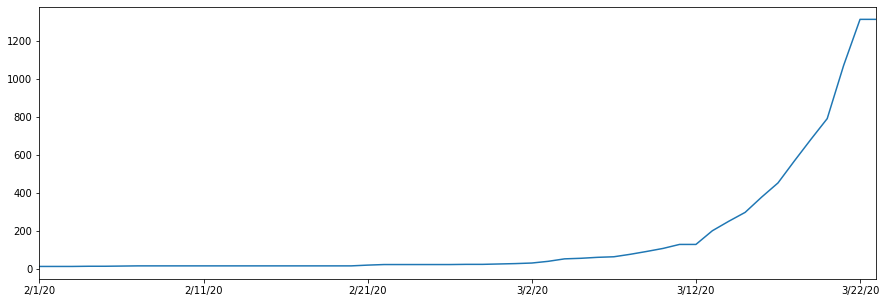

In [173]:
#df.describe().toPandas().transpose()
df_plot = df.drop(*["Province/State","Country/Region", "Lat", "Long"]).toPandas()
df_plot.sum().plot(figsize=(15,5))


**Prediction for whole Australia**

In [258]:
df_australia = df.drop(*["Province/State","Country/Region", "Lat", "Long"])
df_australia_t = t_data(df_australia.groupBy().sum())
df_australia_t = df_australia_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
df_australia_t.show(5)
predict(df_australia_t)

+-----------+-----+----------+
|       Date|Cases|Date_value|
+-----------+-----+----------+
|sum(2/1/20)|   12|         1|
|sum(2/2/20)|   12|         2|
|sum(2/3/20)|   12|         3|
|sum(2/4/20)|   13|         4|
|sum(2/5/20)|   13|         5|
+-----------+-----+----------+
only showing top 5 rows

Coefficients: [50.26843708786918]
Intercept: -1783.5290280354602
numIterations: 3
objectiveHistory: [0.4999999999999999, 0.4113206736317112, 0.09705662939313293]
+--------------------+
|           residuals|
+--------------------+
|  176.67060413577724|
|  129.40216704790805|
|   84.13372996003886|
|  36.865292872169675|
|-0.40314421569951264|
|   -35.6715813035687|
|  -69.94001839143789|
|  -99.20845547930708|
| -149.47689256717604|
| -127.74532965504523|
|  -128.0137667429144|
|  -131.2822038307836|
| -101.55064091865279|
|  -76.81907800652198|
| -11.087515094391165|
|   51.64404781773965|
|  111.37561072987046|
|  341.10717364200127|
+--------------------+

RMSE: 127.464294
r2: 0.8075

**Prediction for individual Province**

In [259]:

for row in df.collect():
    df_state = filter_province(row["Province/State"])
    df_state = df_state.drop(*["Province/State","Country/Region", "Lat", "Long"])
    df_state_t = t_data(df_state)
    df_state_t = df_state_t.select("*").withColumn("Date_value", monotonically_increasing_id()+1)
    print("Prediction for Province/State: " + row["Province/State"])
    predict(df_state_t)
    


Prediction for Province/State: New South Wales
Coefficients: [21.88019584605882]
Intercept: -771.8614609447745
numIterations: 3
objectiveHistory: [0.5, 0.4094703210047335, 0.08028668903793099]
+-------------------+
|          residuals|
+-------------------+
|  71.81499802483347|
|  49.93480217877459|
|  32.05460633271582|
| 12.174410486656939|
|0.29421464059817026|
|-11.585981205460712|
| -26.46617705151948|
| -38.34637289757836|
| -60.22656874363713|
| -55.10676458969601|
| -56.98696043575478|
|-56.867156281813664|
| -41.74735212787243|
|-24.627547973931314|
| 10.492256180009917|
|  28.61206033395115|
|  52.73186448789238|
| 113.85166864183338|
+-------------------+

RMSE: 49.045413
r2: 0.843381
+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|  533|        52|  [52.0]|
|3/22/20|  533|        51|  [51.0]|
+-------+-----+----------+--------+

+--------+------------------+
|features|        prediction|
+--------+------

+-------+-----+----------+--------+
|   Date|Cases|Date_value|features|
+-------+-----+----------+--------+
|3/23/20|    3|        52|  [52.0]|
|3/22/20|    3|        51|  [51.0]|
+-------+-----+----------+--------+

+--------+------------------+
|features|        prediction|
+--------+------------------+
|  [52.0]|1.5973169520531412|
|  [51.0]|1.5404296232861754|
+--------+------------------+

Difference in 3/22/20: 1.4595703767138246
Difference in 3/23/20: 1.4026830479468588


Prediction for Province/State: Australian Capital Territory
Coefficients: [0.3264837659778905]
Intercept: -11.937965176971346
numIterations: 3
objectiveHistory: [0.49999999999999994, 0.4384691192416912, 0.2510351188129972]
+--------------------+
|           residuals|
+--------------------+
|  1.1640008997009588|
|  0.8375171337230682|
|  0.5110333677451777|
| 0.18454960176728719|
|-0.14193416421060334|
|-0.46841793018849387|
| -0.7949016961663844|
|  -1.121385462144275|
| -1.4478692281221655|
|  -0.77435299410